# Neural Network Model for MNIST Dataset
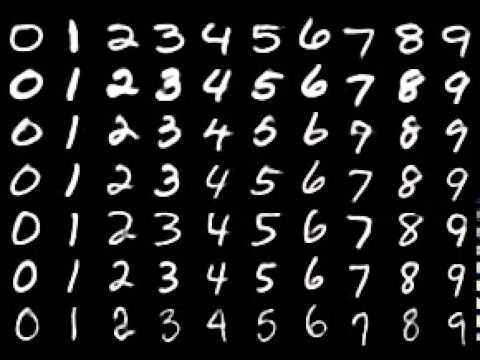


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from copy import deepcopy

# Reproducability and Image Normalization

In [2]:
# Set random seed for reproducibility
random_seed = 1

# For reproducibility, this turns off cudnn's auto-tuner.
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 64
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [3]:
global_mean = 0.5 # MNIST train dataset mean
global_std = 0.5 # MNIST train dataset standard deviation

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((global_mean), (global_std)),
])

In [4]:
data_path = 'datasets/mnst'

if not os.path.exists(data_path):
    download = True
else:
    download = False

train_loader = DataLoader(
    torchvision.datasets.MNIST(
        data_path,
        train=True,
        download=download,
        transform=transform,
        ),
    batch_size=batch_size_train,
    shuffle=True,
    )

val_loader = DataLoader(
    torchvision.datasets.MNIST(
        data_path,
        train=False, 
        download=download,
        transform=transform,
        ),
    batch_size=batch_size_test,
    shuffle=False,
    )

Batch index: 0
Input batch shape: torch.Size([64, 1, 28, 28])
Target batch shape: torch.Size([64])


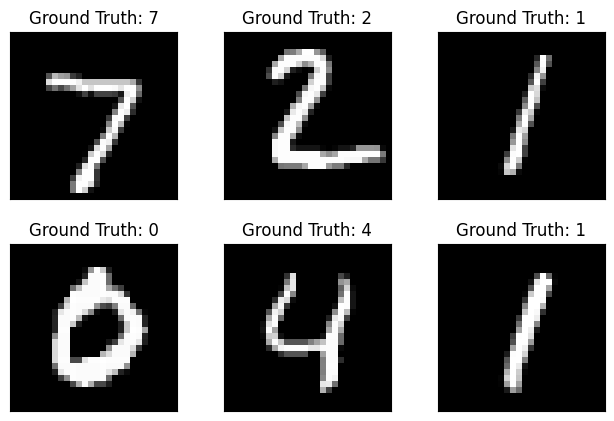

In [5]:
batch = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(batch)
print(f"Batch index: {batch_idx}")
print(f"Input batch shape: {example_data.shape}")
print(f"Target batch shape: {example_targets.shape}")

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

### Building the Network

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=784, n_classes=10, hidden_size=[128, 64]):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], n_classes)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Define training loop

In [7]:
def train_classification(model, data_loader, optimizer, criterion, device):
    model.to(device).train()
    batch_loss = []
    correct = 0
    total_samples = 0

    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        correct += (y_hat.argmax(1) == y).sum().item()
        total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy


def validate_classification(model, data_loader, criterion, device):
    model.to(device).eval()
    batch_loss = []
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            batch_loss.append(loss.item())
            correct += (y_hat.argmax(1) == y).sum().item()
            total_samples += y.size(0)

    accuracy = 100.0 * correct / total_samples
    loss_total = sum(batch_loss) / len(batch_loss)

    return loss_total, accuracy

class EarlyStopper:
    def __init__(
        self, patience: int = 1, min_delta: float = 0.0, verbose: bool = False
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("inf")
        self.best_model_weights = None
        self.verbose = verbose

    def early_stop(self, loss:float, model:nn.Module):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            self.save_best_weights(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early Stopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                return True
        return False

    def save_best_weights(self, model):
        self.best_model_weights = deepcopy(model.state_dict())

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_weights)

In [8]:
# Lists to store loss and accuracy
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

# Training parameters
n_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model, loss function, and optimizer
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

In [9]:
for epoch in tqdm(range(n_epochs), desc='Training Progress'):
    epoch_train_loss, epoch_train_acc = train_classification(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    epoch_val_loss, epoch_val_acc = validate_classification(model, val_loader, criterion, device)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} acc: {epoch_train_acc:.2f}% - Val loss: {epoch_val_loss:.4f} acc: {epoch_val_acc:.2f}%')
    if early_stopper.early_stop(epoch_val_loss, model):
        early_stopper.restore_best_weights(model)
        print("Early Stopping triggered: Restoring best weights")
        break

Training Progress:  20%|██        | 1/5 [00:05<00:22,  5.52s/it]

[1/5] Train loss: 0.7398 acc: 79.45% - Val loss: 0.3652 acc: 89.12%


Training Progress:  40%|████      | 2/5 [00:11<00:18,  6.05s/it]

[2/5] Train loss: 0.3222 acc: 90.49% - Val loss: 0.2921 acc: 91.64%


Training Progress:  60%|██████    | 3/5 [00:18<00:12,  6.43s/it]

[3/5] Train loss: 0.2671 acc: 92.03% - Val loss: 0.2374 acc: 93.00%


Training Progress:  80%|████████  | 4/5 [00:26<00:06,  6.82s/it]

[4/5] Train loss: 0.2230 acc: 93.41% - Val loss: 0.2046 acc: 93.84%


Training Progress: 100%|██████████| 5/5 [00:33<00:00,  6.69s/it]

[5/5] Train loss: 0.1909 acc: 94.47% - Val loss: 0.1817 acc: 94.64%


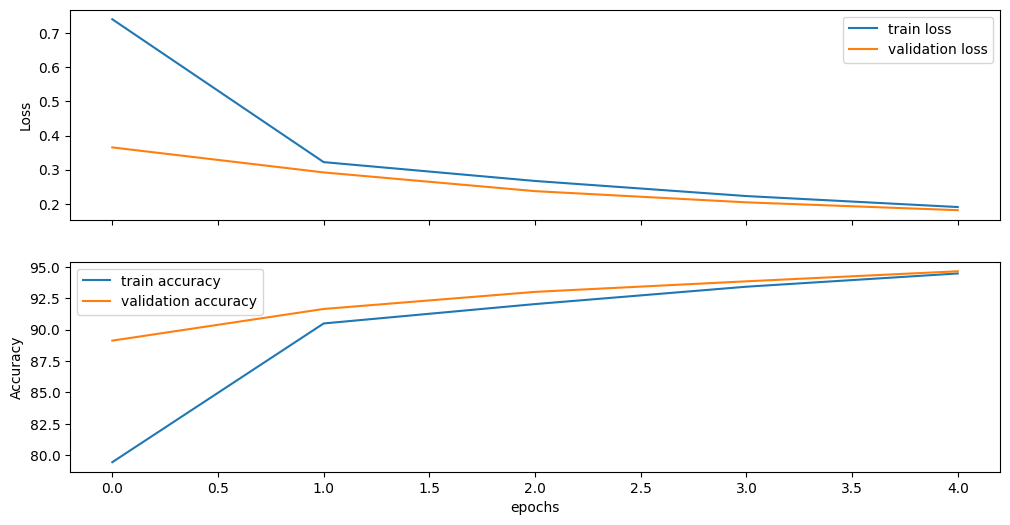

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(train_loss, label="train loss")
ax1.plot(val_loss, label="validation loss")
ax1.set_ylabel("Loss")
ax2.plot(train_accuracy, label="train accuracy")
ax2.plot(val_accuracy, label="validation accuracy")
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("epochs")
ax1.legend()
ax2.legend()